In [7]:
import os, sys

import pandas as pd
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import *

In [8]:
data = pd.read_csv("../data/text.csv").drop(columns="Unnamed: 0")
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [9]:
data.drop_duplicates(inplace= True)

In [11]:
data['tokens'] = data['text'].apply(tokenize)

In [12]:
data['tokens_stemm'] = data['tokens'].apply(stemming).apply(remove_stopwords)

In [13]:
data = data[~(data['tokens_stemm'].apply(len) == 0)]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)
# 0.125 x 0.8 = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [15]:
train_data = pd.concat((X_train,y_train), axis=1).reset_index()
val_data = pd.concat((X_val,y_val), axis=1).reset_index()
test_data = pd.concat((X_test,y_test), axis=1).reset_index()

In [16]:
tokenizer = fit_tokenizer(X_train)

In [20]:
train_data['padded'] = train_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
val_data['padded'] = val_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)
test_data['padded'] = test_data['tokens_stemm'].apply(pad_sequence, tokenizer= tokenizer)

In [21]:
X_train_dataset = PandasDataset(train_data)
X_val_dataset = PandasDataset(val_data)
X_test_dataset = PandasDataset(test_data)

In [22]:
X_train_batched = get_batched_data(X_train_dataset, batch_size= 256)
X_val_batched = get_batched_data(X_val_dataset, batch_size= 64)
X_test_batched = get_batched_data(X_test_dataset, batch_size= 64)

In [23]:
import torch
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class BiLSTMModel(nn.Module):
    def __init__(self, vocabulary_size:int= 52000, 
                 embedding_dim:int= 64, maxlen= 100, 
                 hidden_size:int= 64, num_classes:int= 6,p:float= 0.3):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True)
        self.batchnorm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(p)
        self.dense = nn.Sequential(nn.Linear(hidden_size*2, 64),
                                   nn.ReLU(),
                                   nn.Linear(64, num_classes),
                                   nn.Softmax(dim=1))
        
        self.apply(init_weights)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change shape for LSTM
        _, (x, _) = self.lstm(x)
        x = x.permute(1, 0, 2).contiguous().view(x.size(1), -1)  # Flatten LSTM output
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [38]:
from tqdm import tqdm
def train(model, train_dataloader, val_dataloader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max= num_epochs,
                                                           eta_min= learning_rate / 10)    

    epoch_loss, epoch_acc = [], []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_running_loss = 0.0
        train_correct_predictions = 0
        train_total_predictions = 0    
        for batch in tqdm(train_dataloader):
            inputs = batch['padded'].to(device)
            labels = batch['label'].to(device)    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct_predictions += (predicted == labels).sum().item()
            train_total_predictions += labels.size(0)
        scheduler.step()
        train_epoch_loss = train_running_loss / len(train_dataloader.dataset)
        train_epoch_accuracy = train_correct_predictions / train_total_predictions
        # Validation phase
        model.eval()
        val_correct_predictions = 0
        val_total_predictions = 0
        with torch.no_grad():
            for batch in val_dataloader:
                val_inputs = batch['padded'].to(device)
                val_labels = batch['label'].to(device) 
                val_outputs = model(val_inputs)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
                val_total_predictions += val_labels.size(0)
        val_epoch_accuracy = val_correct_predictions / val_total_predictions
        epoch_loss.append(train_epoch_loss)
        epoch_acc.append(val_epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, '
              f'Val Accuracy: {val_epoch_accuracy:.4f}')
    return model, epoch_loss, epoch_acc

In [41]:
model = BiLSTMModel()

In [42]:
model, losses, accuracies = train(model, X_train_batched, X_val_batched, 10, 0.001)

  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.4055, Train Accuracy: 0.6343, Val Accuracy: 0.7823


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 1.2242, Train Accuracy: 0.8183, Val Accuracy: 0.8411


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 1.1792, Train Accuracy: 0.8640, Val Accuracy: 0.8754


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 1.1634, Train Accuracy: 0.8796, Val Accuracy: 0.8799


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 1.1560, Train Accuracy: 0.8871, Val Accuracy: 0.8816


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 1.1472, Train Accuracy: 0.8962, Val Accuracy: 0.8910


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 1.1361, Train Accuracy: 0.9073, Val Accuracy: 0.9043


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 1.1307, Train Accuracy: 0.9128, Val Accuracy: 0.9077


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 1.1257, Train Accuracy: 0.9177, Val Accuracy: 0.9123


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 1.1230, Train Accuracy: 0.9203, Val Accuracy: 0.9122


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 1.1208, Train Accuracy: 0.9226, Val Accuracy: 0.9148


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 1.1194, Train Accuracy: 0.9239, Val Accuracy: 0.9152


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 1.1180, Train Accuracy: 0.9254, Val Accuracy: 0.9170


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 1.1174, Train Accuracy: 0.9260, Val Accuracy: 0.9167


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 1.1156, Train Accuracy: 0.9278, Val Accuracy: 0.9164


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 1.1147, Train Accuracy: 0.9287, Val Accuracy: 0.9163


  0%|          | 0/1138 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 1.1141, Train Accuracy: 0.9294, Val Accuracy: 0.9168


 70%|██████▉   | 795/1138 [06:10<02:39,  2.14it/s]


KeyboardInterrupt: 

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

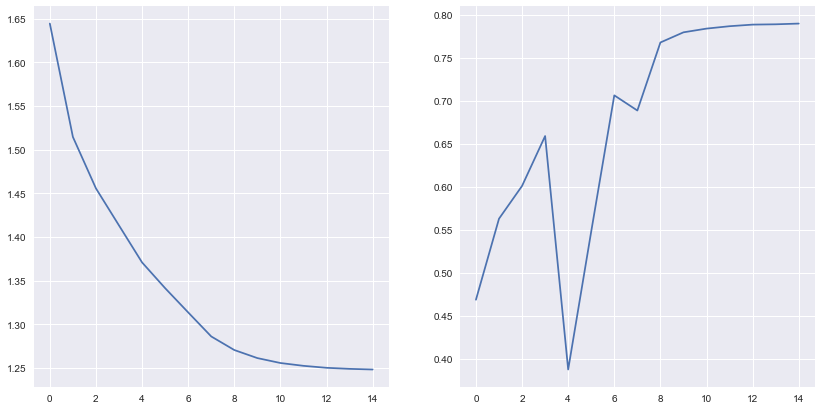

In [43]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2, figsize = (14,7))
sns.lineplot(ax= ax[0], x= range(len(losses)), y= losses)
sns.lineplot(ax= ax[1], x= range(len(accuracies)), y= accuracies)